## Problem set 2
#### Daniela del Río

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
''' Function given by Prof. Jacob Robnson for modelling a neuron with Hodgkin & Huxley.
    Code available in file: HodHux_ELEC380.py
'''
def HodHux_ELEC380(I, dt, plot_activation = 0): 
    #Hodgkin Huxley model of a neuron
    #ELEC 480 Fall 2014
    #JTRobinson
    #
    #Converted from MATLAB to Python by CATuppen Fall 2021
    #
    #Input:
    #I = a vector of current values [uA]
    #dt = time step between I measurments [ms]
    #plot_activation (optional) = 1 to plot the activation state variables vs V (default 0)
    #
    #Output:
    #V = membrane voltage in mV
    #n = sodium activation
    #m = potassium activation
    #h = 1 - potassium inactivation
    #
    #State variables: V, n, m, h
    #
    #DV = 1/C (I - Ik - Ina - Il)
    # 
    # Il = gl(V-El)
    # Ik = gk*n^4(V-Ek)
    # Ina = gna*m^3*h(V-Ena)
    #
    #Dn = (ninf(V) - n)/taun(V)
    #Dm = (minf(V) - m)/taum(V)
    #Dh = (hinf(V) - h)/tauh(V)

    global V
    global m
    global n
    global h
    global gkt
    global gnat
    global Ik
    global Ina
    global Il

    #starting membrane potential;
    Vstart = -65.625 #[mV]

    #Constants:
    #reversal potentials for various ions
    Ek = -77 #[mV]
    Ena = 55 #[mV] Changing these last two values to match the homework specifications
    El = -55.4 #[mV] H&H used approx -55 mV

    #Membrane capacitance:
    C = 1 #[uF]

    #maximum conductances [mS]
    gna = 120
    gk = 36
    gl = 0.3

    #Constants for GHK eq for channel activation
    #from J. Bossu, J Physiol. 496.2 (1996)
    #V50n = 57;
    #kn = 13.5;

    #from Izhikevich pg. 46 (2007)
    #K+ Delayed Rectifier 1: Ik = g*n^4*(V-Ek)

    #activation
    V50n = -50
    kn = 15
    Vmaxn = -79
    sig_n = 50
    Campn = 4.7
    Cbasen = 1.1

    #from Izhikevich pg. 46 (2007)
    #Na+ Fast Transient 1: Ina = g*m^3*h*(V-Ena)

    #activation:
    V50m = -40
    km = 8 #adjusted to match Fig. 2.3 on Pg. 39. probably a typo in the table 
    Vmaxm = -38
    sig_m = 30
    Campm = 0.46
    Cbasem = 0.04

    #inactivation
    V50h = -60
    kh = -7
    Vmaxh = -67
    sig_h = 20
    Camph = 7.4
    Cbaseh = 1.2

    #initialize the vector sizes
    n = np.zeros(len(I))
    m = np.zeros(len(I))
    h = np.zeros(len(I))
    V = np.zeros(len(I))

    #set initial conditions:
    n[0] = 0.3
    m[0] = 0.006
    h[0] = 0.626
    V[0] = Vstart #[mV]
    
    #iterate through the input sequence and calculate the response
    current = np.zeros(len(I))
    I_Nas = np.zeros(len(I))
    I_Ks = np.zeros(len(I))
    I_leaks = np.zeros(len(I))
    
    for ii in range(len(I)-1):
        #update voltage state variable
        #DV = 1/C (I - Ik - Ina - Il)
        
        #units: 
        #I = uA
        #V = mV, g = mS; g*V = uA
        #C = uF 
        #uA/uC*ms = mV
       
        #full model
        V[ii+1] = V[ii] + dt/C*(I[ii] - gl*(V[ii]-El) - gk*n[ii]**4*(V[ii]-Ek) 
                                - gna*m[ii]**3*h[ii]*(V[ii]-Ena))
        
        # Adding this section
        # For finding the current in this time step,
        I_Nas[ii] = (gna*m[ii]**3*h[ii])*(V[ii]-Ena) # We must use the activation and inactivation variables for Na
        I_Ks[ii]  = (gk* n[ii]**4)*(V[ii]-Ek)        # K only has an activation variable in H&H model
        I_leaks[ii] = gl*(V[ii]- El)                 # Leak current only has no activation or inactivation variable

        current[ii] = I_Nas[ii] + I_Ks[ii] + I_leaks[ii]
   
        #steady state activation values at the given voltage
        ninf = 1/( 1 + np.exp( (V50n-V[ii])/kn ) )
        minf = 1/( 1 + np.exp( (V50m-V[ii])/km ) )
        hinf = 1/( 1 + np.exp( (V50h-V[ii])/kh ) )
        
        #time constants
        #Izhikevich pg. 45
        taun = Cbasen + Campn*np.exp(-(Vmaxn-V[ii])**2/sig_n**2)
        taum = Cbasem + Campm*np.exp(-(Vmaxm-V[ii])**2/sig_m**2)
        tauh = Cbaseh + Camph*np.exp(-(Vmaxh-V[ii])**2/sig_h**2)
        
        #update activation state variables
        n[ii+1] = n[ii] + dt*(ninf - n[ii])/taun
        m[ii+1] = m[ii] + dt*(minf - m[ii])/taum
        h[ii+1] = h[ii] + dt*(hinf - h[ii])/tauh
        
    gkt = gk*n**4
    gnat = gna*m**3*h

    Ik = gkt*(V-Ek)
    Ina = gnat*(V-Ena)
    Il = gl*(V-El)

    #Diagnostics
#     if plot_activation:
#         print("The time step is: ",dt)
#         Vtest = np.arange(-100,11) # The x-vector is this one, that is why there are negatives in the x-axis
#                                     # I am not sure if this is supposed to be time or voltage, though...

#         #steady state activation vs Voltage
#         ninfV = 1/( 1 + np.exp((V50n-Vtest)/kn))
#         minfV = 1/( 1 + np.exp((V50m-Vtest)/km))
#         hinfV = 1/( 1 + np.exp((V50h-Vtest)/kh))

#         line1, = plt.plot(Vtest, ninfV, color = 'b', label = r'$n_{infty}$')
#         line2, = plt.plot(Vtest, minfV, color = 'r', label = r'$m_{infty}$')
#         line3, = plt.plot(Vtest, hinfV, color = 'k', label = r'$h_{infty}$')
#         plt.legend(handles=[line1, line2, line3])
#         plt.suptitle('Steady state activations')
#         plt.xlabel("Time [ms]")
#         plt.show()
         
#         #time constants vs Voltage
#         taunV = Cbasen + Campn*np.exp(-(Vmaxn-Vtest)**2/sig_n**2)
#         taumV = Cbasem + Campm*np.exp(-(Vmaxm-Vtest)**2/sig_m**2)
#         tauhV = Cbaseh + Camph*np.exp(-(Vmaxh-Vtest)**2/sig_h**2)

#         line1, = plt.plot(Vtest, taunV, color = 'b', label = r'$tau_{n}$')
#         line2, = plt.plot(Vtest, taumV, color = 'r', label = r'$tau_{m}$')
#         line3, = plt.plot(Vtest, tauhV, color = 'k', label = r'$tau_{h}$')
#         plt.xlabel("Time [ms]")
# #         plt.ylabel("Activation time constants")
#         plt.suptitle('Activation time constants')
#         plt.legend(handles=[line1, line2, line3])
#         plt.show()
        
    return V, current, I_Nas, I_Ks, I_leaks

In [3]:
# Currents
Is_01 = np.zeros(1000) #For a step size of 0.1
Is_01[0:600] = 10 # 60 ms of 10 uA current pulse 

Is_001 = np.zeros(10000) # For a step size of 0.01
Is_001[0:6000] = 10 # 60 ms of 10 uA current pulse 

Is_0001 = np.zeros(100000) # For a step size of 0.001
Is_0001[0:60000] = 10 # 60 ms of 10 uA current pulse 

In [4]:
dts = [0.1, 0.01, 0.001]
V_01, current_01, I_Nas_01, I_Ks_01, I_leaks_01 = HodHux_ELEC380(Is_01, 0.1)
V_001, current_001, I_Nas_001, I_Ks_001, I_leaks_001 = HodHux_ELEC380(Is_001, 0.01)
V_0001, current_0001, I_Nas_0001, I_Ks_0001, I_leaks_0001 = HodHux_ELEC380(Is_0001, 0.001)

/tmp/ipykernel_47952/138260657.py:143: RuntimeWarning: overflow encountered in double_scalars
  taun = Cbasen + Campn*np.exp(-(Vmaxn-V[ii])**2/sig_n**2)
/tmp/ipykernel_47952/138260657.py:144: RuntimeWarning: overflow encountered in double_scalars
  taum = Cbasem + Campm*np.exp(-(Vmaxm-V[ii])**2/sig_m**2)
/tmp/ipykernel_47952/138260657.py:145: RuntimeWarning: overflow encountered in double_scalars
  tauh = Cbaseh + Camph*np.exp(-(Vmaxh-V[ii])**2/sig_h**2)
/tmp/ipykernel_47952/138260657.py:126: RuntimeWarning: overflow encountered in double_scalars
  - gna*m[ii]**3*h[ii]*(V[ii]-Ena))
/tmp/ipykernel_47952/138260657.py:130: RuntimeWarning: overflow encountered in double_scalars
  I_Nas[ii] = (gna*m[ii]**3*h[ii])*(V[ii]-Ena) # We must use the activation and inactivation variables for Na
/tmp/ipykernel_47952/138260657.py:125: RuntimeWarning: invalid value encountered in double_scalars
  V[ii+1] = V[ii] + dt/C*(I[ii] - gl*(V[ii]-El) - gk*n[ii]**4*(V[ii]-Ek)
/tmp/ipykernel_47952/138260657.py:1

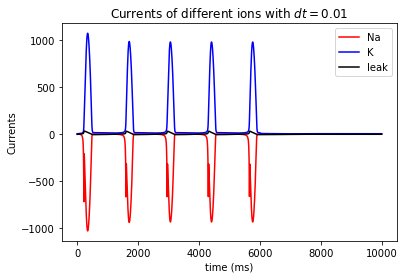

In [5]:
plt.plot(I_Nas_001, color="red", label="Na")
plt.plot(I_Ks_001, color="blue", label="K")
plt.plot(I_leaks_001, color="k", label="leak")
plt.xlabel('time (ms)')
plt.ylabel('Currents') #Not in right units, but with the expected shape!
plt.title(u'Currents of different ions with $dt=0.01$')
plt.legend()
plt.show()

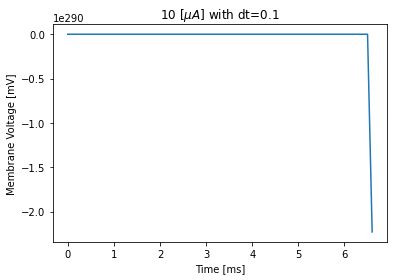

In [6]:
plt.plot([i/10 for i in range(1000)], V_01)
plt.xlabel('Time [ms]')
plt.ylabel('Membrane Voltage [mV]')
plt.title(u'10 [$\mu A$] with dt=0.1')
# plt.savefig('Q2_01.png')
plt.show()

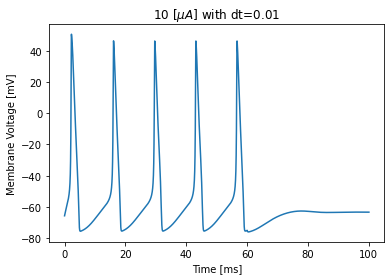

In [7]:
plt.plot([i/100 for i in range(10000)], V_001)
plt.xlabel('Time [ms]')
plt.ylabel('Membrane Voltage [mV]')
plt.title(u'10 [$\mu A$] with dt=0.01')
# plt.savefig('Q2_001.png')
plt.show()

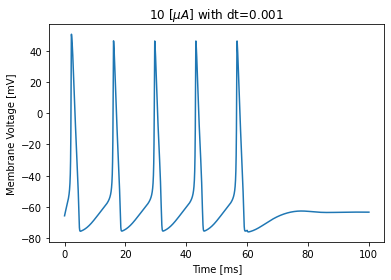

In [8]:
plt.plot([i/100 for i in range(10000)], V_001)
plt.xlabel('Time [ms]')
plt.ylabel('Membrane Voltage [mV]')
plt.title(u'10 [$\mu A$] with dt=0.001')
# plt.savefig('Q2_0001.png')
plt.show()

Using a current amplitude of $2 \mu A$, identify the minimum pulse length that results in a single action potential, and plot the transmembrane current and membrane potential on the first set of axes. Use two y-axes (left and right) on the same plot: one for the transmembrane current and one for the membrane potential. (4 pts)}
    \item\textbf{For the same action potential plotted in 1.3, plot the gating variables n, m, and h as a function of time on the second set of axes (time-aligned to and plotted below the membrane potential plot from 1.3).

In [9]:
# Threshold around 4.6 ms

Is_001 = np.zeros(10000) # For a step size of 0.01
Is_001[0:510] = 2 # 5 ms of 10 uA current pulse

V_001, current_001, I_Nas_001, I_Ks_001, I_leaks_001 = HodHux_ELEC380(Is_001, 0.01)

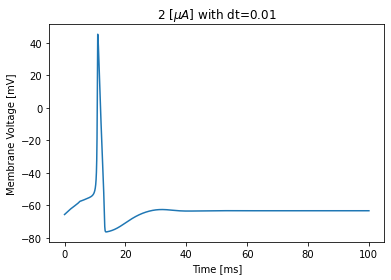

In [10]:
plt.plot([i/100 for i in range(10000)], V_001)
plt.xlabel('Time [ms]')
plt.ylabel('Membrane Voltage [mV]')
plt.title(u'2 [$\mu A$] with dt=0.01')
plt.savefig('Q2_001.png')
plt.show()

## Exercises 1.3-1.6

In [11]:
# Threshold around 4.6 ms

Is_001 = np.zeros(6000) # For a step size of 0.01, 60ms
Is_001[0:510] = 2 # 5.1 ms of 2 uA current pulse

V_001, current_001, I_Nas_001, I_Ks_001, I_leaks_001 = HodHux_ELEC380(Is_001, 0.01)

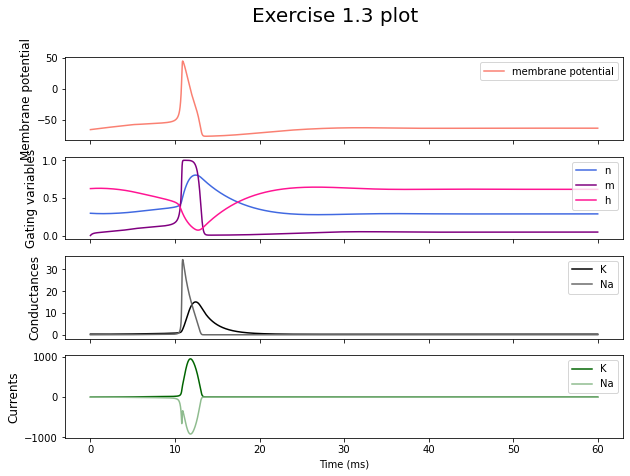

In [12]:
time_units = [i/100 for i in range(6000)]

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, sharex=True, figsize=(10,7))
fig.suptitle('Exercise 1.3 plot', fontsize=20)

# ax1.plot(time_units, I_Nas_1, color="red", label="Na")
ax1.plot(time_units, V_001, color="salmon", label="membrane potential")
# ax1.plot(time_units, V_001, color="salmon", label="membrane potential") # Transmembrane current
ax1.set_ylabel("Membrane potential", fontsize=12)
ax1.legend()

# ax2.plot(time_units, I_Ks_1, color="blue", label="K")
ax2.plot(time_units, n, color="royalblue", label="n")
ax2.plot(time_units, m, color="purple", label="m")
ax2.plot(time_units, h, color="deeppink", label="h")
ax2.set_ylabel(u"Gating variables", fontsize=12)
ax2.legend()

ax3.plot(time_units, gkt, color="k", label="K")
ax3.plot(time_units, gnat, color="dimgrey", label="Na")
ax3.set_ylabel("Conductances", fontsize=12)
ax3.legend()

ax4.plot(time_units, Ik, color="darkgreen", label="K")
ax4.plot(time_units, Ina, color="darkseagreen", label="Na")
ax4.set_ylabel("Currents", fontsize=12)
ax4.legend()

plt.xlabel('Time (ms)') #Not in the correct time units
# plt.ylim([-50, 50])
plt.show()

For checking to see if an action potential occured, see that the maximum voltage was above a certain value.

For the transmembrane current, Anne said "Transmembrane current is the current across the membrane. You can calculate that based on some of the outputs of the function. Based on the circuit drawing you created in 1.1, which function outputs could be used to calculate transmembrane current?"

The output of the ``HodHux_ELEC380`` function:

- ``V`` = membrane voltage in mV
- ``n`` = sodium activation
- ``m`` = potassium activation
- ``h`` = 1 - potassium inactivation

# Question 2

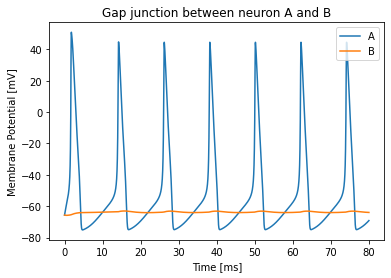

In [13]:
I_A = np.zeros(8000)
I_A[0:8000] = 15 # uA

V_A, current_A, I_Nas_A, I_Ks_A, I_leaks_A = HodHux_ELEC380(I_A, 0.01)

I_B = V_A/(0.15)/1000 # V=RI, obtain I=V/R, where R=0.15 M Ohms and V_A is in mV
# We want I_B to be in microAmps, so we divide by a factor of 1000

# The previous expression calculated with Ohm's law is the input to neuron B
V_B, current_B, I_Nas_B, I_Ks_B, I_leaks_B = HodHux_ELEC380(I_B, 0.01)

plt.plot([i/100 for i in range(8000)],V_A, label = "A")
plt.plot([i/100 for i in range(8000)], V_B, label = "B")
plt.title('Gap junction between neuron A and B')
plt.ylabel('Membrane Potential [mV]')
plt.xlabel('Time [ms]')
plt.legend()
plt.show()

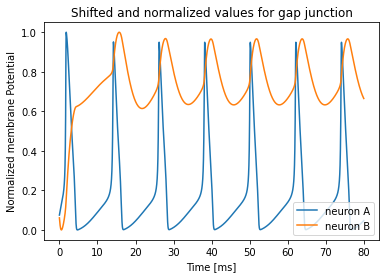

In [14]:
# Normalizing the values,
plt.plot([i/100 for i in range(8000)],(V_A+abs(min(V_A)))/(max(V_A)+abs(min(V_A))), label = "neuron A")
plt.plot([i/100 for i in range(8000)], (V_B+abs(min(V_B)))/(max(V_B)+abs(min(V_B))), label = "neuron B")
plt.title('Shifted and normalized values for gap junction')
plt.ylabel('Normalized membrane Potential')
plt.xlabel('Time [ms]')
plt.legend(loc="lower right")
plt.show()

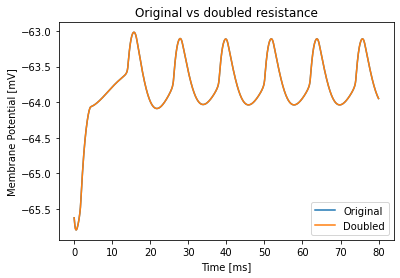

In [15]:
# 2c
# Increase resistance by a factor of 2
I_A = np.zeros(8000)
I_A[0:8000] = 15 # uA

V_A, current_A, I_Nas_A, I_Ks_A, I_leaks_A = HodHux_ELEC380(I_A, 0.01)

I_B_2 = V_A/(2*0.15*1000000)/1000 # V=RI, obtain I=V/R, where R=0.15 M Ohms and V_A is in mV
# We want I_B to be in microAmps, so we divide by a factor of 1000

# The previous expression calculated with Ohm's law is the input to neuron B
V_B_2, current_B_2, I_Nas_B_2, I_Ks_B_2, I_leaks_B_2 = HodHux_ELEC380(I_B, 0.01)

plt.plot([i/100 for i in range(8000)],V_B, label = "Original")
plt.plot([i/100 for i in range(8000)], V_B_2, label = "Doubled")
plt.title('Original vs doubled resistance')
plt.ylabel('Membrane Potential [mV]')
plt.xlabel('Time [ms]')
plt.legend()
plt.show()

# Question 3.1

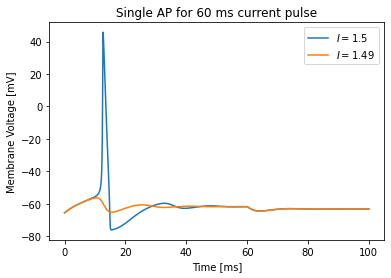

In [17]:
# Threshold around 4.6 ms

Is_15 = np.zeros(10000) # For a step size of 0.01
Is_149 = np.zeros(10000) # For a step size of 0.01
Is_15[0:6000] = 1.5 # 60 ms of x uA current pulse
Is_149[0:6000] = 1.49 # 60 ms of x uA current pulse

V_15, current_15, I_Nas_15, I_Ks_15, I_leaks_15 = HodHux_ELEC380(Is_15, 0.01)
V_149, current_149, I_Nas_149, I_Ks_149, I_leaks_149 = HodHux_ELEC380(Is_149, 0.01)

plt.plot([i/100 for i in range(10000)], V_15, label=u"$I=1.5$")
plt.plot([i/100 for i in range(10000)], V_149, label=u"$I=1.49$")
plt.xlabel('Time [ms]')
plt.ylabel('Membrane Voltage [mV]')
plt.title(u'Single AP for 60 ms current pulse')
plt.legend()
# plt.savefig('single_AP.png')
plt.show()

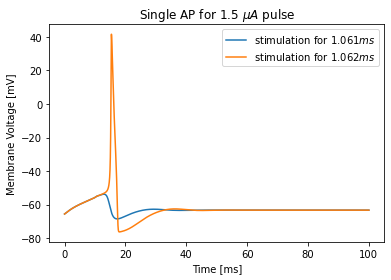

In [18]:
Is_1 = np.zeros(10000) # For a step size of 0.01
Is_2 = np.zeros(10000) # For a step size of 0.01
Is_1[0:1061] = 1.5 # 1.061 ms of x uA current pulse
Is_2[0:1062] = 1.5 # 1.062 ms of x uA current pulse

V_1, current_1, I_Nas_1, I_Ks_1, I_leaks_1 = HodHux_ELEC380(Is_1, 0.01)
V_2, current_2, I_Nas_2, I_Ks_2, I_leaks_2 = HodHux_ELEC380(Is_2, 0.01)

plt.plot([i/100 for i in range(10000)], V_1, label=u"stimulation for $1.061 ms$")
plt.plot([i/100 for i in range(10000)], V_2, label=u"stimulation for $1.062 ms$")
plt.xlabel('Time [ms]')
plt.ylabel('Membrane Voltage [mV]')
plt.title(u'Single AP for 1.5 $\mu A$ pulse')
plt.legend()
# plt.savefig('single_AP_15_pulse.png')
plt.show()

In [19]:
print(min(I_Nas_2)) # Minimum Na current
print(max(I_Ks_2)) # Max K current
print(max(I_leaks_2)) # Max leak current

-857.4660052119
894.1482513785169
29.103124172660323


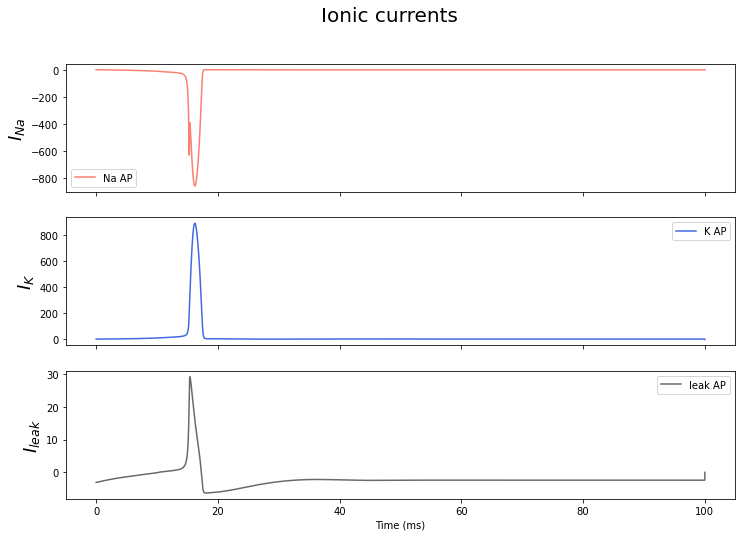

In [20]:
time_units = [i/100 for i in range(10000)]

fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, figsize=(12,8))
fig.suptitle('Ionic currents', fontsize=20)

# ax1.plot(time_units, I_Nas_1, color="red", label="Na")
ax1.plot(time_units, I_Nas_2, color="salmon", label="Na AP")
ax1.set_ylabel(u"$I_{Na}$", fontsize=18)
ax1.legend()

# ax2.plot(time_units, I_Ks_1, color="blue", label="K")
ax2.plot(time_units, I_Ks_2, color="royalblue", label="K AP")
ax2.set_ylabel(u"$I_{K}$", fontsize=18)
ax2.legend()

# ax3.plot(time_units, I_leaks_1, color="k", label="leak")
ax3.plot(time_units, I_leaks_2, color="dimgrey", label="leak AP")
ax3.set_ylabel(u"$I_{leak}$", fontsize=18)
ax3.legend()

plt.xlabel('Time (ms)') #Not in the correct time units
# plt.ylim([-50, 50])
plt.show()